In [2]:
from typing import Optional, Tuple, List, Dict, Any, Union
import os
from pathlib import Path
import numpy as np
from glob import glob
import glob
import random
import pandas as pd
import matplotlib.pyplot as plt
import pickle


import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, Dice, BinaryPrecision, BinaryRecall
from torchvision import transforms
import segmentation_models_pytorch as smp

In [3]:
class GeoImageDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = os.listdir(self.img_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        # mask and img_file have so far the same name
        mask_path = os.path.join(self.mask_dir, self.img_files[idx])
        img = torch.load(img_path)
        # converts bool mask into integer (0/1)
        mask = torch.load(mask_path).long()
        # Apply transform (if any)
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)

        return img, mask

In [4]:
def train(
    dataloader: Any,
    model: nn.Module,
    loss_fn: Any,
    optimizer: Any,
) -> Union[torch.Tensor, List[float]]:
    size = len(dataloader.dataset)
    loss_vals=  []
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        
        loss = loss_fn(pred, y.to(torch.float32)) # pred.squeeze(1)
        loss_vals.append(loss.item())
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    avg_loss = np.mean(loss_vals)
    return avg_loss, loss_vals

In [5]:
def test(dataloader: Any, model: nn.Module, loss_fn: Any) -> Union[torch.Tensor, torch.Tensor, List[float]]:
    loss_vals=  []
    Dice_idx_vals = []
    # size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0
    test_dice = 0
    test_f1 = 0
    test_precision = 0
    test_recall = 0
    metric = Dice(mode="binary", zero_division=1).to(device)
    f1_score = BinaryF1Score(multidim_average='global').to(device)
    precision = BinaryPrecision(multidim_average='global').to(device)
    recall = BinaryRecall(multidim_average='global').to(device)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y.to(torch.float32)).item() # pred.squeeze(1)
            test_loss += loss
            dice = metric(pred, y.to(torch.int8))
            loss_vals.append(loss)
            test_dice += dice.item()
            Dice_idx_vals.append(dice.item())
            test_f1 += f1_score(pred, y.to(torch.int8)).item()
            test_precision += precision(pred, y.to(torch.int8)).item()
            test_recall += recall(pred, y.to(torch.int8)).item()

    test_loss /= num_batches
    test_dice /= num_batches
    test_f1 /= num_batches
    test_precision /= num_batches
    test_recall /= num_batches
    # correct /= size

    # Dice_idx = 100 * metric(pred, y)
    print(
        f"Test Error: \n"
        f"Dice-Coefficient: {test_dice:>0.2f}, Avg loss: {test_loss:>5f} \n"
    )

    return test_loss, loss_vals, test_dice, Dice_idx_vals, test_f1, test_precision, test_recall

In [6]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [40]:
root = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned_verified")

train_images_path = Path(root / "train/images")
train_masks_path = Path(root / "train/masks")
val_images_path = Path(root / "val/images")
val_masks_path = Path(root / "val/masks")
test_images_path = Path(root / "test/images")
test_masks_path = Path(root / "test/masks")

In [41]:
# transform = transforms.Compose([
#     #transforms.RandomRotation(degrees=(0, 360)).get_params([0, 90, 180, 270]),
#     transforms.RandomHorizontalFlip(p=0.5),
# ])
transform = transforms.RandomHorizontalFlip(p=0.5)
# transform = None

In [42]:
train_dataset = GeoImageDataset(train_images_path, train_masks_path, transform=transform)
val_dataset = GeoImageDataset(val_images_path, val_masks_path, transform=transform)
test_dataset = GeoImageDataset(test_images_path, test_masks_path, transform=transform)

In [43]:
batch_size = 16
shuffle = True

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

In [44]:
print(f"Size train set: {train_dataset.__len__()}")
print(f"Size val set: {val_dataset.__len__()}")
print(f"Size test set: {test_dataset.__len__()}")

Size train set: 11703
Size val set: 3899
Size test set: 1595


In [12]:
model = smp.Unet(
    encoder_name='efficientnet-b0',
    encoder_weights='imagenet',
    in_channels=4,
    classes=1,
    activation='sigmoid',
).to(device)

In [45]:
epochs = 2
max_lr = 0.01

optimizer = Adam(model.parameters(), lr=max_lr)

scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(train_dataloader),epochs=epochs)

# loss_fn = smp.losses.DiceLoss(mode="binary", log_loss=False, from_logits=False)
loss_fn = nn.BCELoss()

In [26]:
sampling = "undersampling"
validated = "cleaned_verified"
epochs = 2
transform = "None"

for backbone in ["efficientnet-b0"]:
    model = smp.Unet(
        encoder_name=backbone,
        encoder_weights='imagenet',
        in_channels=4,
        classes=1,
        activation='sigmoid',
    ).to(device)
    train_loss_steps = []
    validation_loss_steps = []
    validation_dice_steps = []
    validation_f1_epochs = []
    validation_precision_epochs = []
    validation_recall_epochs = []

    train_loss_epochs = []
    val_loss_epochs = []
    val_dice_epochs = []

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        # loss, val_loss, dice, dice_list, validation_f1_epochs, test_precision_epochs, validation_recall_epochs = test(val_dataloader, model, loss_fn)
        loss, train_loss = train(train_dataloader, model, loss_fn, optimizer)
        train_loss_steps.extend(train_loss)
        train_loss_epochs.append(loss)
        loss, val_loss, dice, dice_list, f1_score, precision, recall = test(val_dataloader, model, loss_fn)
        validation_loss_steps.extend(val_loss)
        val_loss_epochs.append(loss)
        val_dice_epochs.append(dice)
        validation_dice_steps.extend(dice_list)
        validation_f1_epochs.append(f1_score)
        validation_precision_epochs.append(precision)
        validation_recall_epochs.append(recall)
        scheduler.step()

    filename = f"u_net_{sampling}_{validated}_{backbone}_{epochs}_{batch_size}_{max_lr}_{transform}"
    torch.save(model.state_dict(), f"models/{filename}.pt")
    data_dict = {
        "train_loss_epochs": train_loss_epochs,
        "val_loss_epochs": val_loss_epochs,
        "val_dice_epochs": val_dice_epochs,
        "validation_f1_epochs": validation_f1_epochs,
        "validation_precision_epochs": validation_precision_epochs,
        "validation_recall_epochs": validation_recall_epochs,
    }
    save_as_csv(data_dict, f"trainings_results/{filename}")

    steps_dict = {
        "train_loss_steps": train_loss_steps,
        "validation_loss_steps": validation_loss_steps,
        "validation_dice_steps": validation_dice_steps,
    }

    data_dict.update(steps_dict)

    save_as_pickle(data_dict, f"trainings_results/{filename}")
    print(f"Model {backbone} trained and saved")
print("Done!")

Epoch 1
-------------------------------
loss: 0.656937  [   16/11703]
loss: 0.659631  [  176/11703]
loss: 0.656618  [  336/11703]
loss: 0.645479  [  496/11703]
loss: 0.648264  [  656/11703]
loss: 0.651975  [  816/11703]
loss: 0.649137  [  976/11703]


KeyboardInterrupt: 

In [14]:
def save_as_csv(data_dict: dict, filename: str) -> None:
    df = pd.DataFrame.from_dict(data_dict)
    df.to_csv(f"{filename}.csv", index=False)

def save_as_pickle(data_dict: dict, filename: str) -> None:
    with open(f"{filename}.pkl", 'wb') as f:
        pickle.dump(data_dict, f)

In [22]:
sampling = "undersampling"
validated = "cleaned_verified"
epochs = 2
transform = "None"

for backbone in ["efficientnet-b0"]:
    model = smp.Unet(
        encoder_name=backbone,
        encoder_weights='imagenet',
        in_channels=4,
        classes=1,
        activation='sigmoid',
    ).to(device)
    train_and_save(model, loss_fn, optimizer, scheduler, epochs, transform,train_dataloader, val_dataloader, test_dataloader)
    print(f"Model {backbone} trained and saved")
print("Done!")

Epoch 1
-------------------------------
loss: 0.535827  [   16/11703]
loss: 0.535326  [  176/11703]
loss: 0.539159  [  336/11703]
loss: 0.535118  [  496/11703]
loss: 0.536790  [  656/11703]
loss: 0.539614  [  816/11703]
loss: 0.539637  [  976/11703]
loss: 0.537082  [ 1136/11703]
loss: 0.538421  [ 1296/11703]
loss: 0.536677  [ 1456/11703]
loss: 0.539491  [ 1616/11703]
loss: 0.537112  [ 1776/11703]
loss: 0.537072  [ 1936/11703]


KeyboardInterrupt: 

In [34]:
class Trainer:
    def __init__(self, loss_fn, max_lr, epochs, transform):
        # self.model = model
        self.loss_fn = loss_fn
        self.max_lr = max_lr
        self.epochs = epochs
        self.transform = transform

        self.train_loss_steps = []
        self.validation_loss_steps = []
        self.validation_dice_steps = []
        self.validation_f1_epochs = []
        self.validation_precision_epochs = []
        self.validation_recall_epochs = []

        self.train_loss_epochs = []
        self.val_loss_epochs = []
        self.val_dice_epochs = []

        self.device = (
            "cuda"
            if torch.cuda.is_available()
            else "mps"
            if torch.backends.mps.is_available()
            else "cpu"
        )

    def train_and_save(self, model, train_dataloader, val_dataloader, sampling, validated, backbone, batch_size):
        optimizer = Adam(model.parameters(), lr=self.max_lr)

        scheduler = OneCycleLR(
            optimizer,
            max_lr=self.max_lr,
            steps_per_epoch=len(train_dataloader),
            epochs=self.epochs,
        )
        filename = f"u_net_{sampling}_{validated}_{backbone}_{self.epochs}_{batch_size}_{self.max_lr}_{self.transform}"
        for t in range(self.epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            loss, train_loss = self.train(model, train_dataloader, optimizer)
            self.train_loss_steps.extend(train_loss)
            self.train_loss_epochs.append(loss)
            loss, val_loss, dice, dice_list, f1_score, precision, recall = self.test(model, val_dataloader)
            self.validation_loss_steps.extend(val_loss)
            self.val_loss_epochs.append(loss)
            self.val_dice_epochs.append(dice)
            self.validation_dice_steps.extend(dice_list)
            self.validation_f1_epochs.append(f1_score)
            self.validation_precision_epochs.append(precision)
            self.validation_recall_epochs.append(recall)
            if dice >= np.max(self.val_dice_epochs):
                torch.save(
                    model.state_dict(),
                    f"models/{filename}_best_model.pt",
                )
                print("Model saved!")
            scheduler.step()

        
        data_dict = {
            "train_loss_epochs": self.train_loss_epochs,
            "val_loss_epochs": self.val_loss_epochs,
            "val_dice_epochs": self.val_dice_epochs,
            "validation_f1_epochs": self.validation_f1_epochs,
            "validation_precision_epochs": self.validation_precision_epochs,
            "validation_recall_epochs": self.validation_recall_epochs,
        }
        self.save_as_csv(data_dict, f"trainings_results/{filename}")
        steps_dict = {
            "train_loss_steps": self.train_loss_steps,
            "validation_loss_steps": self.validation_loss_steps,
            "validation_dice_steps": self.validation_dice_steps,
        }
        data_dict.update(steps_dict)
        self.save_as_pickle(data_dict, f"trainings_results/{filename}")
        torch.save(model.state_dict(), f"models/{filename}.pt")

    def train(
        self,
        model: nn.Module,
        dataloader: Any,
        optimizer: Any,
    ) -> Union[torch.Tensor, List[float]]:
        size = len(dataloader.dataset)
        loss_vals= []
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(self.device), y.to(self.device)

            pred = model(X)
            
            loss = self.loss_fn(pred, y.to(torch.float32)) # pred.squeeze(1)
            loss_vals.append(loss.item())
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch % 20 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        avg_loss = np.mean(loss_vals)
        return avg_loss, loss_vals

    def test(
            self, 
            model: nn.Module, 
            dataloader: Any
        ) -> Union[torch.Tensor, torch.Tensor, List[float]]:
        loss_vals=  []
        Dice_idx_vals = []
        # size = len(dataloader.dataset)
        num_batches = len(dataloader)
        model.eval()
        test_loss = 0
        test_dice = 0
        test_f1 = 0
        test_precision = 0
        test_recall = 0
        metric = Dice(mode="binary", zero_division=1).to(self.device)
        f1_score = BinaryF1Score(multidim_average='global').to(self.device)
        precision = BinaryPrecision(multidim_average='global').to(self.device)
        recall = BinaryRecall(multidim_average='global').to(self.device)

        with torch.no_grad():
            for X, y in dataloader:
                X, y = X.to(device), y.to(device)
                pred = model(X)
                loss = self.loss_fn(pred, y.to(torch.float32)).item() # pred.squeeze(1)
                test_loss += loss
                dice = metric(pred, y.to(torch.int8))
                loss_vals.append(loss)
                test_dice += dice.item()
                Dice_idx_vals.append(dice.item())
                test_f1 += f1_score(pred, y.to(torch.int8)).item()
                test_precision += precision(pred, y.to(torch.int8)).item()
                test_recall += recall(pred, y.to(torch.int8)).item()

        test_loss /= num_batches
        test_dice /= num_batches
        test_f1 /= num_batches
        test_precision /= num_batches
        test_recall /= num_batches
        # correct /= size

        # Dice_idx = 100 * metric(pred, y)
        print(
            f"Test Error: \n"
            f"Dice-Coefficient: {test_dice:>0.2f}, Avg loss: {test_loss:>5f} \n"
        )

        return test_loss, loss_vals, test_dice, Dice_idx_vals, test_f1, test_precision, test_recall

    def save_as_csv(self, data_dict: dict, filename: str) -> None:
        df = pd.DataFrame.from_dict(data_dict)
        df.to_csv(f"{filename}.csv", index=False)

    def save_as_pickle(self, data_dict: dict, filename: str) -> None:
        with open(f"{filename}.pkl", 'wb') as f:
            pickle.dump(data_dict, f)

In [46]:
sampling = "undersampling"
validated = "cleaned_verified"
epochs = 20
transform = "RandomHorizontalFlip"
max_lr = 0.005

for backbone in ["timm-resnest14d"]:
    model = smp.Unet(
        encoder_name=backbone,
        encoder_weights='imagenet',
        in_channels=4,
        classes=1,
        activation='sigmoid',
    ).to(device)
    trainer = Trainer(loss_fn, max_lr=max_lr, epochs=epochs, transform=transform)
    trainer.train_and_save(model, train_dataloader, val_dataloader, sampling, validated, backbone, batch_size)
    print(f"Model {backbone} trained and saved")
print("Done!")

Epoch 1
-------------------------------
loss: 1.018527  [   16/11703]
loss: 0.664777  [  336/11703]
loss: 0.460651  [  656/11703]
loss: 0.349265  [  976/11703]
loss: 0.274839  [ 1296/11703]
loss: 0.235685  [ 1616/11703]
loss: 0.187433  [ 1936/11703]
loss: 0.158274  [ 2256/11703]
loss: 0.139738  [ 2576/11703]
loss: 0.128087  [ 2896/11703]
loss: 0.107918  [ 3216/11703]
loss: 0.090520  [ 3536/11703]
loss: 0.098353  [ 3856/11703]
loss: 0.091310  [ 4176/11703]
loss: 0.066893  [ 4496/11703]
loss: 0.065676  [ 4816/11703]
loss: 0.061862  [ 5136/11703]
loss: 0.053915  [ 5456/11703]
loss: 0.055708  [ 5776/11703]
loss: 0.061787  [ 6096/11703]
loss: 0.049334  [ 6416/11703]
loss: 0.073434  [ 6736/11703]
loss: 0.080299  [ 7056/11703]
loss: 0.033851  [ 7376/11703]
loss: 0.035804  [ 7696/11703]
loss: 0.034427  [ 8016/11703]
loss: 0.037349  [ 8336/11703]
loss: 0.030415  [ 8656/11703]
loss: 0.027601  [ 8976/11703]
loss: 0.040095  [ 9296/11703]
loss: 0.040680  [ 9616/11703]
loss: 0.034682  [ 9936/11703]


In [18]:
filename = f"u_net_{sampling}_{validated}_{backbone}_{epochs}_{batch_size}_{max_lr}_{transform}"

In [19]:
data_dict = {
    "train_loss_epochs": train_loss_epochs,
    "val_loss_epochs": val_loss_epochs,
    "val_dice_epochs": val_dice_epochs,
    "validation_f1_epochs": validation_f1_epochs,
    "validation_precision_epochs": validation_precision_epochs,
    "validation_recall_epochs": validation_recall_epochs,
}

In [23]:
save_as_csv(data_dict, filename)

In [20]:
steps_dict = {
    "train_loss_steps": train_loss_steps,
    "validation_loss_steps": validation_loss_steps,
    "validation_dice_steps": validation_dice_steps,
}

In [24]:
data_dict.update(steps_dict)

In [25]:
save_as_pickle(data_dict, filename)

In [15]:
epochs_lists = [train_loss_epochs, val_loss_epochs, val_dice_epochs, validation_f1_epochs, validation_precision_epochs, validation_recall_epochs]

In [ ]:
lists = [train_loss_steps, validation_loss_steps, validation_dice_steps]
save_as_pickle(lists, "")

In [38]:
validation_recall_epochs

[0.6627129975259304]

In [28]:
print('train_loss_vals: ', len(train_loss_vals))
print('val_loss_vals: ', len(val_loss_vals))
print('val_jaccard_idx_vals: ', len(val_jaccard_idx_vals))

train_loss_vals:  5715
val_loss_vals:  1635
val_jaccard_idx_vals:  1635


In [29]:
#save model
torch.save(model.state_dict(),r'C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\Notebooks\ML_Modell\models\model_efficientnet_b0_undersampling_cleaned.pt')

#### Train Loss

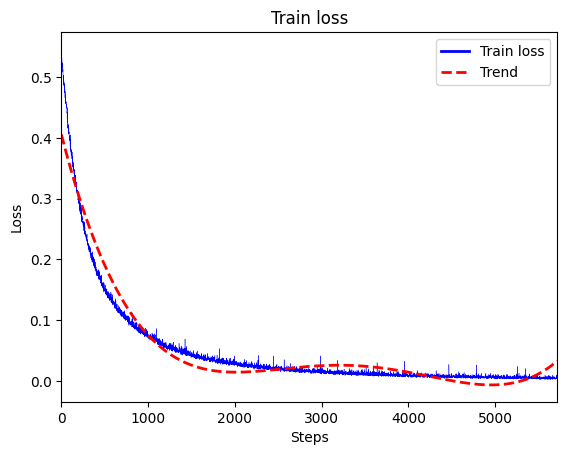

In [31]:
epochs = range(1, len(train_loss_vals) + 1)

# Add trend curve
z_jaccard = np.polyfit(epochs, train_loss_vals, 4)
p_jaccard = np.poly1d(z_jaccard)
plt.plot(train_loss_vals, 'b', label='Train loss', linewidth=0.3)
plt.plot(epochs, p_jaccard(epochs), "r--", label='Trend', linewidth=2)

plt.title('Train loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.xlim(0, len(train_loss_vals))
# plt.ylim(0, 1)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

#### Validation Loss

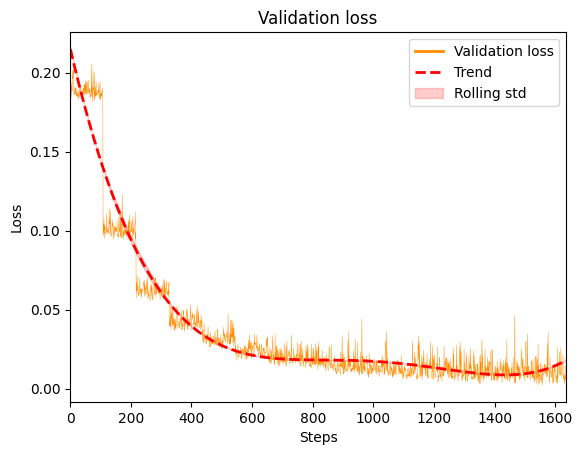

In [32]:
epochs = range(1, len(val_loss_vals) + 1)
orange = '#FF8C00'
# Add trend curve
z_jaccard = np.polyfit(epochs, val_loss_vals, 4)
p_jaccard = np.poly1d(z_jaccard)

plt.plot(val_loss_vals, color=orange, label='Validation loss', linewidth=0.3)
plt.plot(epochs, p_jaccard(epochs), "r--", label='Trend',  linewidth=2)

window_size = 200
rolling_std = pd.Series(val_loss_vals).rolling(window_size, min_periods=1).var().values

plt.fill_between(epochs, p_jaccard(epochs)-rolling_std, p_jaccard(epochs)+rolling_std, alpha=0.2, color='red', label='Rolling std')

plt.title('Validation loss')
plt.xlabel('Steps')
plt.ylabel('Loss')

plt.xlim(0, len(val_loss_vals))
# plt.ylim(0, 1)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

#### Dice Coefficient

In [129]:
epochs = range(1, len(val_dice_idx_vals) + 1)

# Add trend curve
z_dice = np.polyfit(epochs, val_dice_idx_vals, 4)
p_dice = np.poly1d(z_dice)
plt.plot(val_dice_idx_vals, 'g', label='Dice Koeff.', linewidth=0.3)
plt.plot(epochs, p_dice(epochs), "r--", label='Trend', linewidth=2)

plt.title('Dice Koeff.')
plt.xlabel('Steps')
plt.ylabel('Dice Koeff.')
plt.xlim(0, len(val_dice_idx_vals))
plt.ylim(0, 1)
leg = plt.legend()
for line in leg.get_lines():
    line.set_linewidth(2)
plt.show()

NameError: name 'val_dice_idx_vals' is not defined

In [184]:
np.isnan(val_jaccard_idx_vals).sum()

15

#### Combine Validation Loss and Jaccard Index (IoU) in one plot

not used in the paper

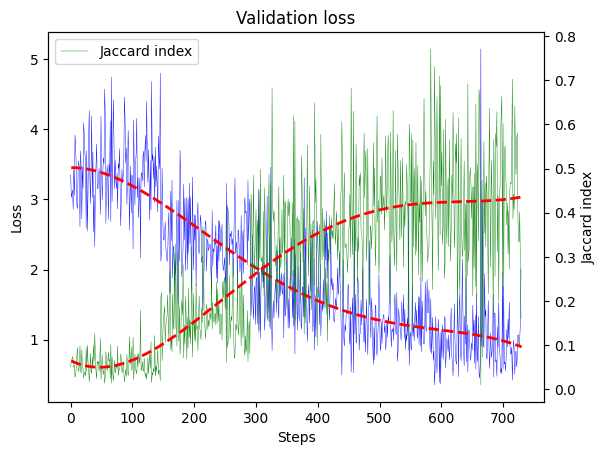

In [18]:
epochs = range(1, len(val_jaccard_idx_vals) + 1)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
z_loss = np.polyfit(epochs, val_loss_vals, 4)
p_loss= np.poly1d(z_loss)
ax1.plot(val_loss_vals, 'b', label='Validation loss', linewidth=0.3, zorder=1)

ax1.set_xlabel('Steps')
ax1.set_ylabel('Loss')


z_jaccard = np.polyfit(epochs, val_jaccard_idx_vals, 4)
p_jaccard = np.poly1d(z_jaccard)
ax2.plot(val_jaccard_idx_vals, 'g', label='Jaccard index', linewidth=0.3, zorder=2)

ax1.plot(epochs, p_loss(epochs), "r--", linewidth=2, zorder=10)
ax2.plot(epochs, p_jaccard(epochs), "r--", linewidth=2, zorder=10)

ax2.set_ylabel('Jaccard index')
plt.title('Validation loss')
plt.xlabel('Steps')
plt.legend()
plt.show()

### Create plot on epoch level

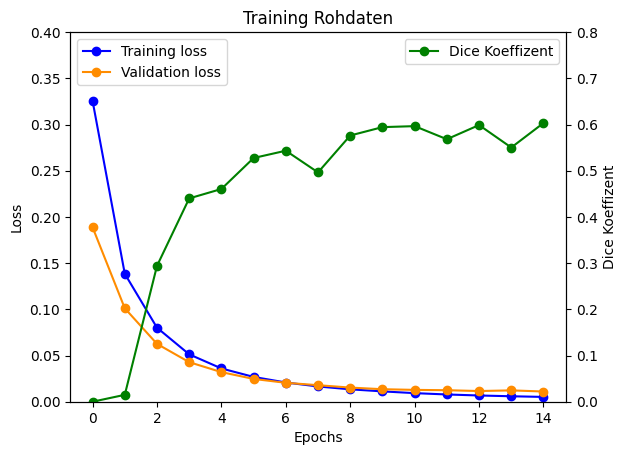

In [130]:
epochs = range(1, len(train_loss_single) + 1)
orange = '#FF8C00'
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(train_loss_single, 'b-o', label='Training loss')
ax1.plot(val_loss_single, '-o', color=orange, label='Validation loss')
ax2.plot(val_jaccard_idx_single, 'g-o', label='Dice Koeffizent')
plt.title('Training Rohdaten')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
ax2.set_ylabel('Dice Koeffizent')
# plt.xlim(0, len(train_loss_single))
ax1.set_ylim(0, 0.4)
ax2.set_ylim(0, 0.8)
# plt.legend()
plt.show()

In [52]:
df = pd.DataFrame({'train_loss': train_loss_single, 'test_loss': val_loss_single, 'jaccard': val_jaccard_idx_single_cpu})
df

NameError: name 'val_jaccard_idx_single_cpu' is not defined

In [33]:
df.to_csv('loss_epochs_10_raw.csv', index=False)

In [34]:
with open('loss_steps_epochs_10_raw.pkl', 'wb') as f:
    pickle.dump([train_loss_vals, val_loss_vals, val_jaccard_idx_vals], f)

In [145]:
# Laden der Listen aus der Datei
with open('loss_steps_epochs_2.pkl', 'rb') as f:
    loaded_lists = pickle.load(f)

In [ ]:
def save_as_csv(lists, filename):
    df = pd.DataFrame({'train_loss': lists[0], 'test_loss': lists[1], 'jaccard': lists[2]})
    df.to_csv(f"{filename}.csv", index=False)

def save_as_pickle(lists, filename):
    with open(f"{filename}.pkl", 'wb') as f:
        pickle.dump(lists, f)

Create plotting function to save it easily

In [143]:
def plot_figure(data, data_label, xlabel, ylabel, ax=ax1, color='blue', xlim=None, ylim=None, legend=True, trend=False, trend_label='Trend', marker='-', linewidth=1):  
    epochs = range(1, len(data) + 1)

    # Add trend curve
    z_data = np.polyfit(epochs, data, 6)
    p_data = np.poly1d(z_data)
    ax.plot(data, marker, color=color, label=data_label, linewidth=linewidth)
    if trend:
        ax.plot(epochs, p_data(epochs), "r--", label=trend_label, linewidth=2)

    # ax.title(title)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlim(0, len(data))
    if ylim != None:
        ax.set_xlim(0, ylim)


    if legend:
        leg = ax.legend()
        for line in leg.get_lines():
            line.set_linewidth(2)

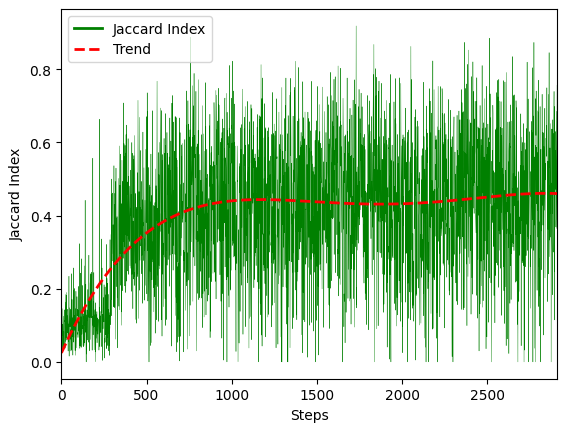

In [162]:
fig, ax1 = plt.subplots()
plot_figure(val_jaccard_idx_vals, 'Jaccard Index', 'Steps', 'Jaccard Index',ax=ax1, color='g',trend=True, linewidth=0.3)

(0.0, 0.8)

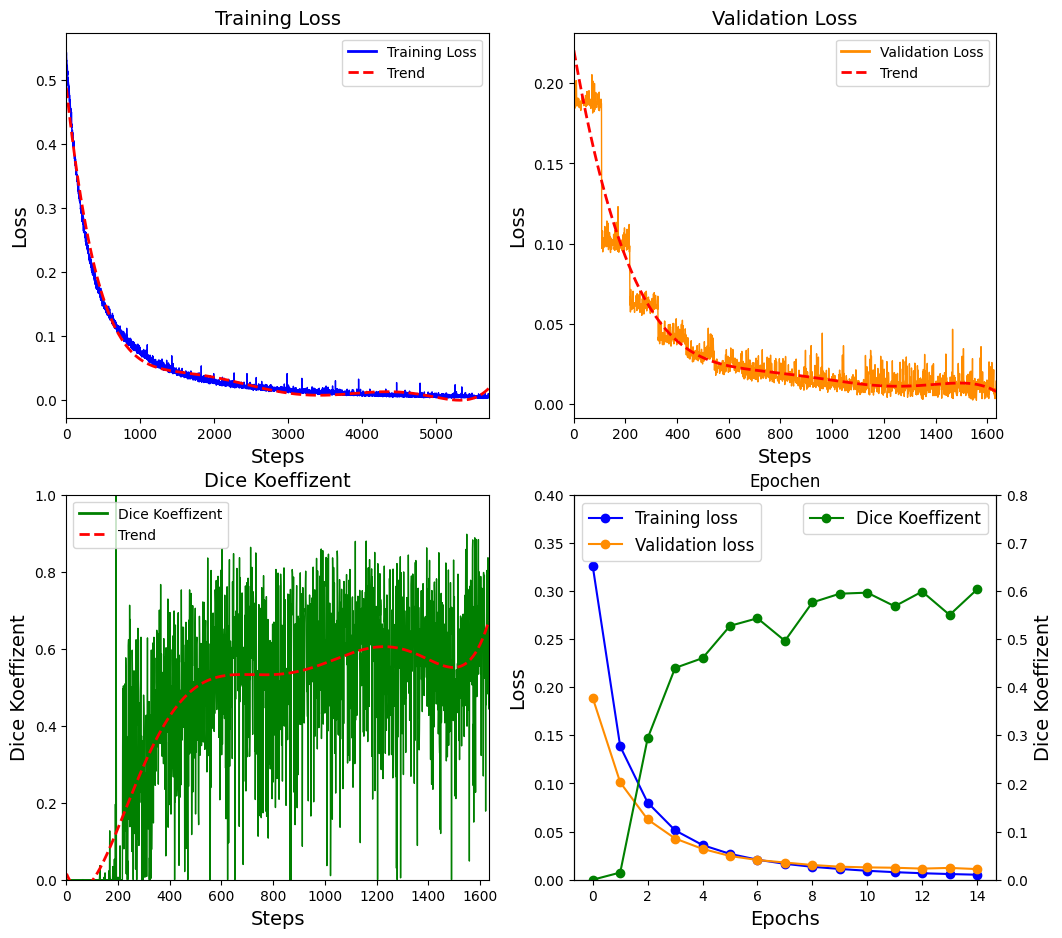

In [149]:
orange = '#FF8C00'
gray = '#808080'
# plt.rcParams.update({'font.weight': 'normal'})
# plt.rcParams.update({'font.size': 10})
fig, axs = plt.subplots(2,2, figsize=(12, 11))
train_plot = plot_figure(train_loss_vals, 'Training Loss', 'Steps', 'Loss', ax=axs[0, 0], color='b', trend=True)
axs[0, 0].set_title('Training Loss', fontsize=14)
loss_plot = plot_figure(val_loss_vals, 'Validation Loss', 'Steps', 'Loss', ax=axs[0, 1], color=orange, trend=True)
axs[0, 1].set_title('Validation Loss', fontsize=14)
jaccard_plot = plot_figure(val_jaccard_idx_vals, 'Dice Koeffizent', 'Steps', 'Dice Koeffizent', ax=axs[1, 0], color='g', trend=True)
axs[1, 0].set_title('Dice Koeffizent', fontsize=14)
axs[1, 0].set_ylim(0, 1)

ax4a = axs[1, 1]
ax4b = ax4a.twinx()
axs[1, 1].set_title('Epochen')
ax4a.plot(train_loss_single, 'b-o', label='Training loss')
ax4a.plot(val_loss_single, '-o', color=orange, label='Validation loss')

# ax4 = ax3.twinx()
ax4b.plot(val_jaccard_idx_single, 'g-o', label='Dice Koeffizent')
ax4a.set_xlabel('Epochs', fontsize=14)
ax4a.set_ylabel('Loss', fontsize=14)
ax4b.set_ylabel('Dice Koeffizent', fontsize=14)
ax4a.legend(loc='upper left', fontsize=12)
ax4b.legend(loc='upper right', fontsize=12)
ax4a.set_ylim(0, 0.4)
ax4b.set_ylim(0, 0.8)

In [150]:
# save figure
fig.savefig('figures/cleaned_data/training_cleaned_grid.pdf', bbox_inches='tight')

### Test set 

In [21]:
test_loss_vals = []
test_jaccard_idx_vals = []

test_loss_single = []
test_jaccard_idx_single = []

loss, test_loss, jaccard_idx, jaccard_idx_list  = test(test_dataloader, model, loss_fn)
test_loss_vals.extend(test_loss)
test_loss_single.append(loss)
test_jaccard_idx_single.append(jaccard_idx)
test_jaccard_idx_vals.extend(jaccard_idx_list)

Test Error: 
Jaccard-Index: 5.724%, Avg loss: 1.519714 



In [22]:
print(f'Jaccard Index on test set: {round(np.mean(test_jaccard_idx_vals)*100, 2)} %', )

Jaccard Index on test set: 34.59 %


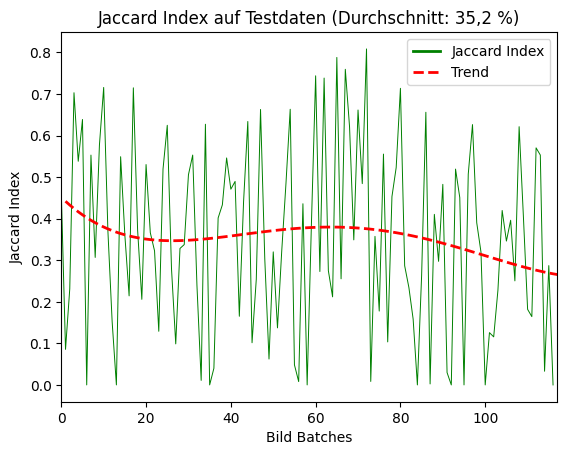

In [212]:
fig, ax1 = plt.subplots()
ax1.set_title('Jaccard Index auf Testdaten (Durchschnitt: 35,24 %)')
plot_figure(test_jaccard_idx_vals, 'Jaccard Index', 'Bild Batches', 'Jaccard Index',ax=ax1, color='g',trend=True, trend_label='Durchschnitt', linewidth=0.7)

In [220]:
fig.savefig('figures/raw_data/test_data_jaccard_raw.pdf', bbox_inches='tight')

#### Check the Validation set on which images the model performs worst (outliers)

Not the test set to prevent data leakage

In [45]:
import rasterio

In [52]:
class GeoImageDataset(Dataset):
    def __init__(self, img_dir: Path, mask_dir:Path, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_files = os.listdir(self.img_dir)
        self.mask_files = os.listdir(self.mask_dir)
        self.transform = transform
        

    def __len__(self):
        return len(self.img_files)
        
    def __getitem__(self, idx):
        # Load image
        img_path = self.img_dir / self.img_files[idx]
        # mask and img_file have so far the same name
        mask_path = self.mask_dir / self.img_files[idx]
        img = torch.load(img_path)
        # converts bool mask into integer (0/1)
        mask = torch.load(mask_path).long()
        # Apply transform (if any)
        if self.transform:
            img = self.transform(img)
        
        return img, mask, img_path, mask_path

In [53]:
val_images_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned\val\images")
val_masks_path = Path(r"C:\Users\Fabian\Documents\Github_Masterthesis\Solarpark-detection\data_local\data_splitted_undersampling_cleaned\val\masks")

val_dataset = GeoImageDataset(val_images_path, val_masks_path)

In [54]:
model.eval() # enabling the eval mode to test with new samples.
metric = Dice(mode="binary", zero_division=1).to(device)

In [55]:
index_list = []
metric_list = []
mask_size_list = []
brightness_image_list = []
img_path_list = []
mask_path_list = []
pred_list = []

for i, sample in enumerate(val_dataset):
    img, mask, img_path, mask_path = val_dataset[i]

    img = img.to(device)
    mask = mask.to(device)
    # Skip images with no mask (jaccard will fail)
    if mask.sum() <= 1:
        continue
    with torch.no_grad():
        pred = model(img.unsqueeze(0))

    IoU = metric(pred[:,0], mask).detach().cpu().numpy()
    index_list.append(i)
    metric_list.append(IoU)
    mask_size_list.append(mask.sum().cpu().numpy())
    brightness_image_list.append(img.mean().cpu().numpy())
    img_path_list.append(img_path)
    mask_path_list.append(mask_path)
    pred_list.append(pred[:,0].detach().cpu().numpy())

df = pd.DataFrame({'index': index_list, 'metric': metric_list, 'mask_size': mask_size_list, 'brightness': brightness_image_list,'pred_mask': pred_list, 'img_path': img_path_list, 'mask_path': mask_path_list})

df = df.sort_values('metric', ascending=False)

df = df.reset_index(drop=True)

df.head()

,index,metric,mask_size,brightness,pred_mask,img_path,mask_path
0,3152,0.97610545,1829,0.3034925,"[[[0.019063642, 0.010352551, 0.009026726, 0.00...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
1,3165,0.96670246,7622,0.25805163,"[[[0.019926539, 0.010068828, 0.008858083, 0.00...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
2,318,0.965,782,0.26232404,"[[[0.020272307, 0.012077396, 0.009866188, 0.00...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
3,3153,0.9618703,1829,0.29417557,"[[[0.019726135, 0.010594434, 0.008552142, 0.00...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
4,94,0.958613,882,0.22008204,"[[[0.021366045, 0.0142937405, 0.015383388, 0.0...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...


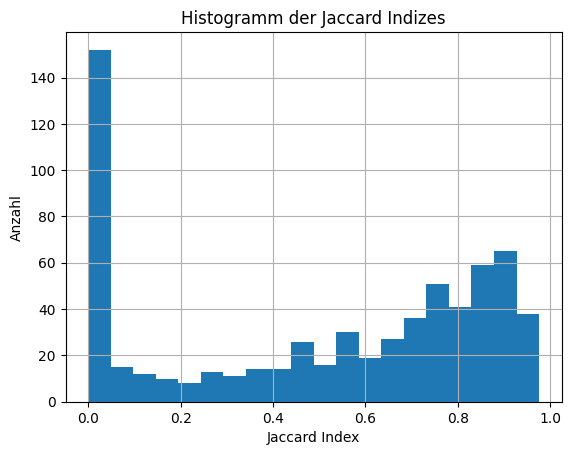

In [56]:
plt.hist(df['metric'], bins=20, )
# add grid
plt.grid(True)
plt.xlabel('Jaccard Index')
plt.ylabel('Anzahl')
plt.title('Histogramm der Jaccard Indizes');

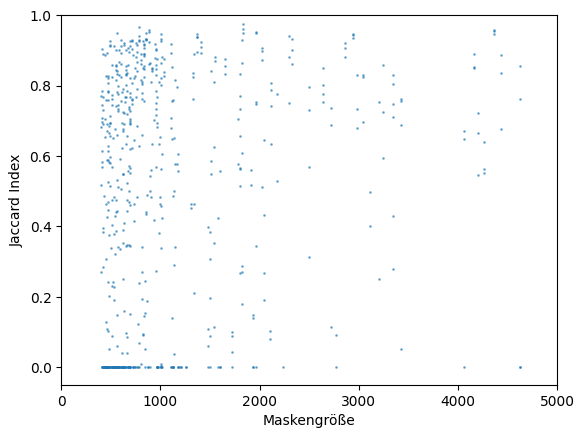

In [58]:

z = np.polyfit(mask_size_list, metric_list, 2)
p = np.poly1d(z)
plt.scatter(mask_size_list, metric_list, s=1, alpha=0.5)
# Zeichnen Sie die Trendlinie
# plt.plot(mask_size_list, p(mask_size_list), 'r--')
# Labeln Sie die Achsen
plt.xlabel('Maskengröße')
plt.ylabel('Jaccard Index')
plt.xlim(0, 5000)
plt.ylim(-0.05, 1)
# Zeigen Sie den Plot an
plt.show()

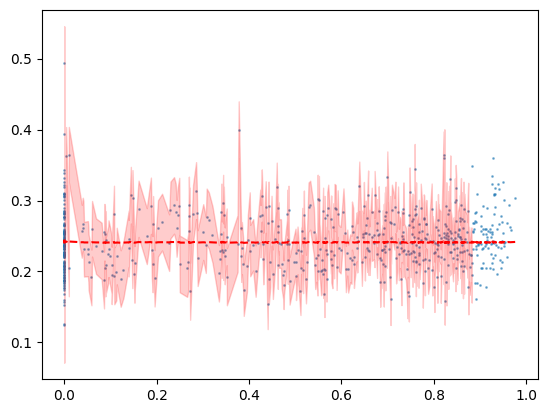

In [59]:
brightness = list(df["brightness"])
metric = list(df["metric"])


window_size = 100
rolling_std = df['brightness'].rolling(window_size, min_periods=100).std().values
z = np.polyfit(metric, brightness, 1)
p = np.poly1d(z)

plt.plot(metric, p(brightness), 'r--')
plt.scatter(metric,brightness, s=1, alpha=0.5)
plt.fill_between(metric, brightness-rolling_std, brightness+rolling_std, alpha=0.2, color='red', label='Rolling std')

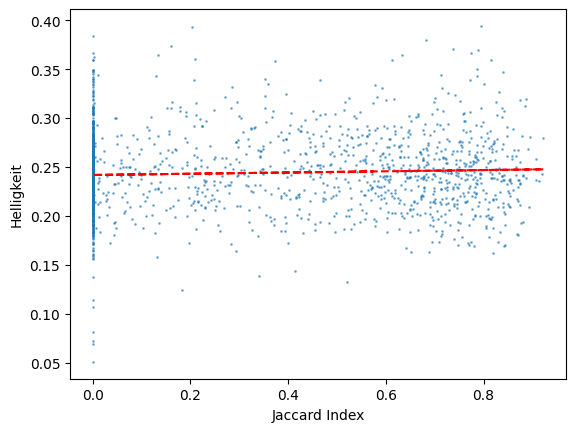

In [63]:
plt.scatter(metric_list, brightness_image_list, s=1, alpha=0.5)

p = np.polyfit(metric_list, brightness_image_list, 1)
y_fit = np.polyval(p, metric_list)

# Zeichnen Sie die Trendlinie
plt.plot(metric_list, y_fit, 'r--')
# Labeln Sie die Achsen
plt.ylabel('Helligkeit')
plt.xlabel('Jaccard Index')

# Zeigen Sie den Plot an
plt.show()

In [63]:
df

,index,metric,mask_size,brightness,pred_mask,img_path,mask_path
0,3152,0.97610545,1829,0.3034925,"[[[0.019063642, 0.010352551, 0.009026726, 0.00...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
1,3165,0.96670246,7622,0.25805163,"[[[0.019926539, 0.010068828, 0.008858083, 0.00...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
2,318,0.965,782,0.26232404,"[[[0.020272307, 0.012077396, 0.009866188, 0.00...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
3,3153,0.9618703,1829,0.29417557,"[[[0.019726135, 0.010594434, 0.008552142, 0.00...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
4,94,0.958613,882,0.22008204,"[[[0.021366045, 0.0142937405, 0.015383388, 0.0...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
...,...,...,...,...,...,...,...
652,1464,0.0,426,0.2464509,"[[[0.019689921, 0.010757979, 0.00900148, 0.007...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
653,1463,0.0,426,0.24850881,"[[[0.02051392, 0.0131030185, 0.017903615, 0.01...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
654,3128,0.0,549,0.21533743,"[[[0.02607462, 0.011886824, 0.009931039, 0.006...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...
655,1454,0.0,443,0.30669534,"[[[0.016430473, 0.010033866, 0.013693966, 0.01...",C:\Users\Fabian\Documents\Github_Masterthesis\...,C:\Users\Fabian\Documents\Github_Masterthesis\...


In [181]:
df.isna().sum()

index         0
metric        0
mask_size     0
brightness    0
pred_mask     0
img_path      0
mask_path     0
dtype: int64

#### Show good performing images

In [125]:
def show_rgb_sample(sample, ax=ax1, show_image=True, show_mask=True, show_pred=True, show_title=True, title='Image', show_axis=False,):
    if show_image:
        img = torch.load(sample.img_path)
        ax.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)))
    
    if show_mask:
        mask = torch.load(sample.mask_path)[0,:,:,]
        ax.imshow(torch.Tensor.numpy(mask), cmap='jet') #, alpha=0.5*(mask==True)

    if show_pred:
        pred = sample.pred_mask[0,:,:]
        ax.imshow(pred, cmap='jet') # , alpha=0.5*(pred>0.5)

    if show_title:
        ax.set_title(title, fontsize=18)

    if not show_axis:
        ax.axis('off')

In [122]:
sample_good_pred = df.iloc[1]
sample_medium_pred = df.iloc[306]
sample_bad_pred = df.iloc[-1]
sample_miss_labeled = df.iloc[402]

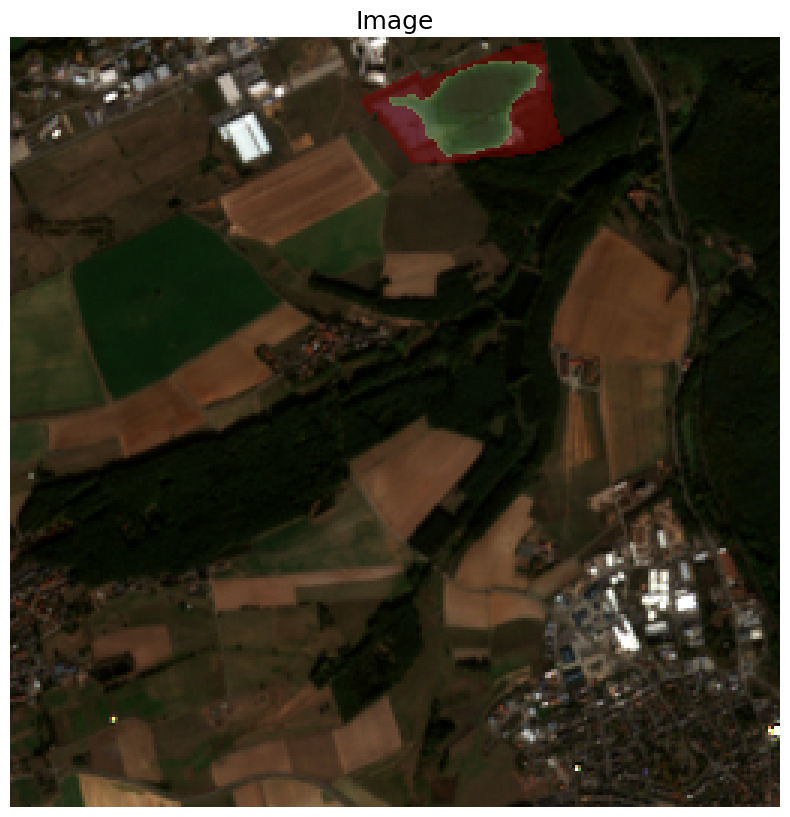

In [121]:
sample = df.iloc[306]
fig, ax1 = plt.subplots(figsize=(10, 10))
show_rgb_sample(sample, ax=ax1, show_image=True, show_mask=True, show_pred=True, show_title=True, title='Image', show_axis=False,)

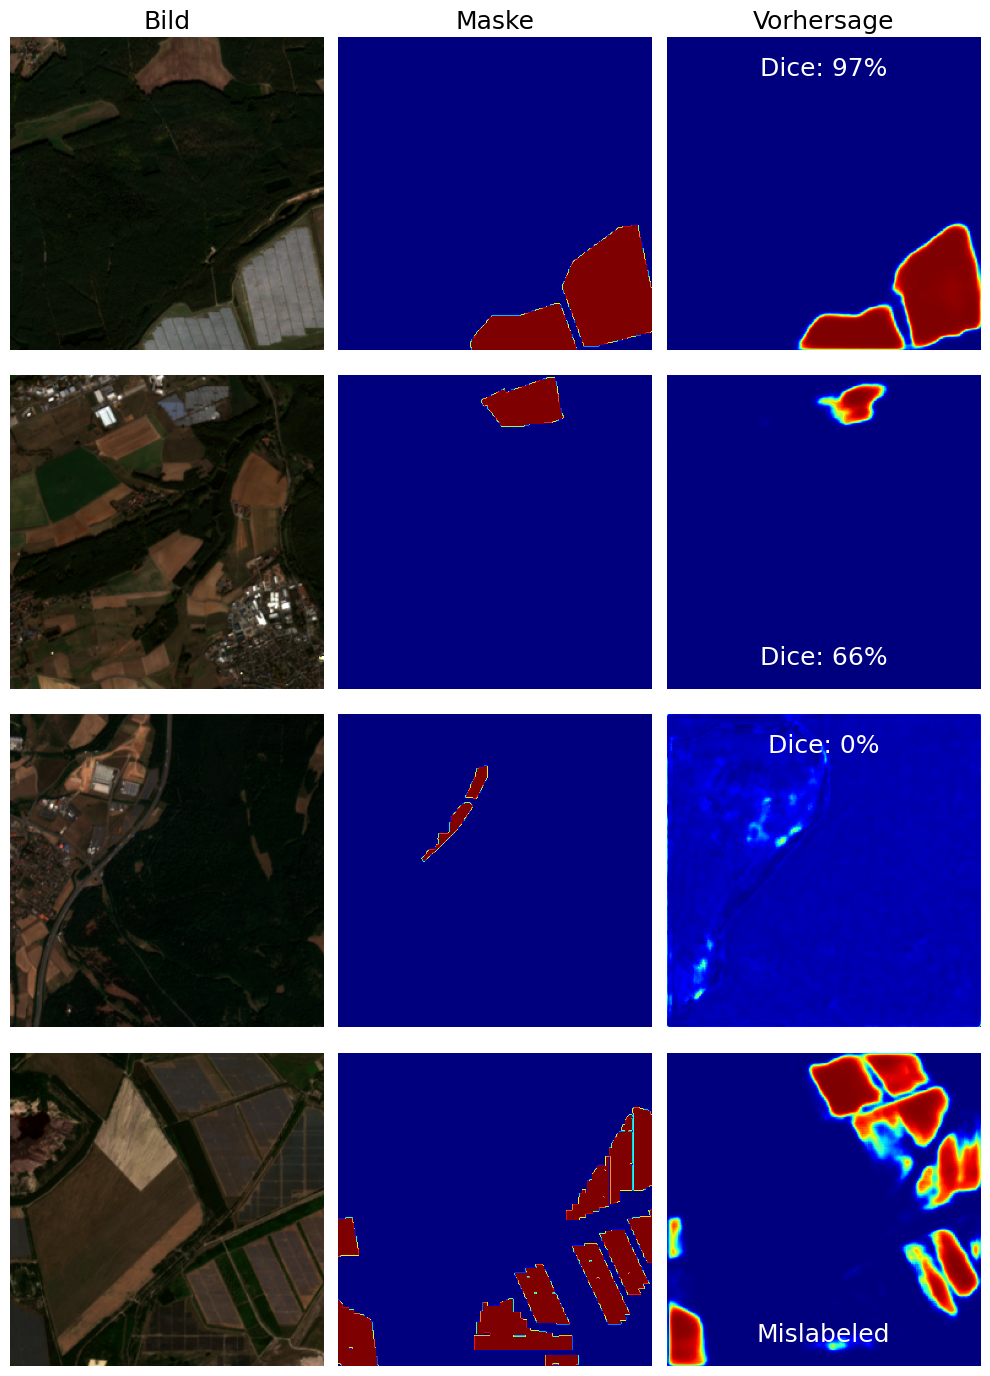

In [153]:
fig, axes = plt.subplots(4, 3, figsize=(10,14))
ax11, ax12, ax13 = axes[0]
ax21, ax22, ax23 = axes[1]
ax31, ax32, ax33 = axes[2]
ax41, ax42, ax43 = axes[3]

show_rgb_sample(sample_good_pred, ax11, show_mask=False, show_pred=False, show_title=True, title='Bild')
show_rgb_sample(sample_good_pred, ax12, show_image=False, show_pred=False, show_title=True, title='Maske')
show_rgb_sample(sample_good_pred, ax13, show_image=False, show_mask=False, show_title=True, title='Vorhersage')
ax13.text(0.5, 0.9, f'Dice: {sample_good_pred.metric:.0%}', horizontalalignment='center', verticalalignment='center', transform=ax13.transAxes, fontsize=18, color='white')

show_rgb_sample(sample_medium_pred, ax21, show_mask=False, show_pred=False, show_title=False, title='Bild')
show_rgb_sample(sample_medium_pred, ax22, show_image=False, show_pred=False, show_title=False, title='Maske')
show_rgb_sample(sample_medium_pred, ax23, show_image=False, show_mask=False, show_title=False, title='Vorhersage')
ax23.text(0.5, 0.1, f'Dice: {sample_medium_pred.metric:.0%}', horizontalalignment='center', verticalalignment='center', transform=ax23.transAxes, fontsize=18, color='white')
# ax21.set_xlim(0, 100)
# ax22.set_xlim(0, 100)
# ax23.set_xlim(0, 100)
# ax21.set_ylim(150, 250)
# ax22.set_ylim(150, 250)
# ax23.set_ylim(150, 250)

show_rgb_sample(sample_bad_pred, ax31, show_mask=False, show_pred=False, show_title=False, title='Bild')
show_rgb_sample(sample_bad_pred, ax32, show_image=False, show_pred=False, show_title=False, title='Maske')
show_rgb_sample(sample_bad_pred, ax33, show_image=False, show_mask=False, show_title=False, title='Vorhersage')
ax33.text(0.5, 0.9, f'Dice: {sample_bad_pred.metric:.0%}', horizontalalignment='center', verticalalignment='center', transform=ax33.transAxes, fontsize=18, color='white')

show_rgb_sample(sample_miss_labeled, ax41, show_mask=False, show_pred=False, show_title=False, title='Bild')
show_rgb_sample(sample_miss_labeled, ax42, show_image=False, show_pred=False, show_title=False, title='Maske')
show_rgb_sample(sample_miss_labeled, ax43, show_image=False, show_mask=False, show_title=False, title='Vorhersage')
ax43.text(0.5, 0.1, f'Mislabeled', horizontalalignment='center', verticalalignment='center', transform=ax43.transAxes, fontsize=18, color='white')

fig.tight_layout()

In [152]:
fig.savefig('figures/cleaned_data/prediction_samples_cleaned.pdf', bbox_inches='tight')

In [94]:
pred.shape

(1, 256, 256)

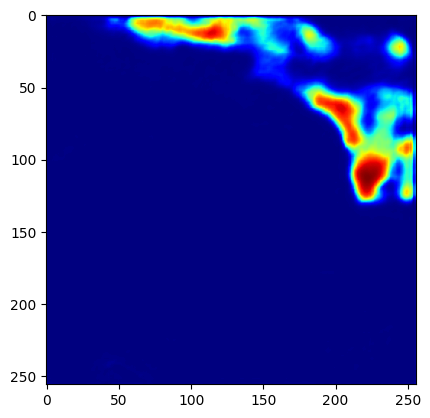

In [106]:
plt.imshow(pred[0,:,:], cmap='jet');

In [46]:
sample.img_path.name

'32UNE_447_2018-11-16.pt'

In [51]:
sample

index                                                      1154
metric                                                0.6101309
mask_size                                                  1567
brightness                                           0.23113611
pred_mask     [[[0.04032828, 0.008616758, 0.008594354, 0.010...
img_path      C:\Users\Fabian\Documents\Github_Masterthesis\...
mask_path     C:\Users\Fabian\Documents\Github_Masterthesis\...
Name: 128, dtype: object

In [296]:
mask = mask[:,:,0]

In [297]:
mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1]], dtype=uint8)

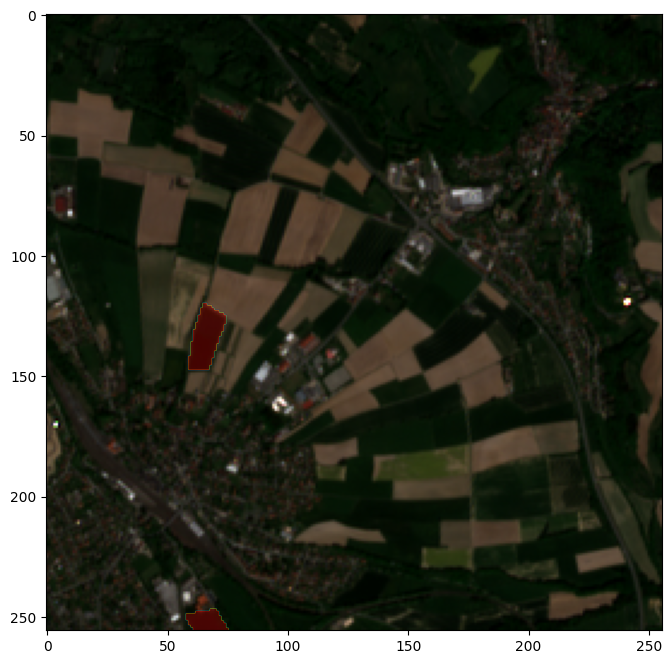

In [301]:
show_rgb_samples(df.iloc[913])

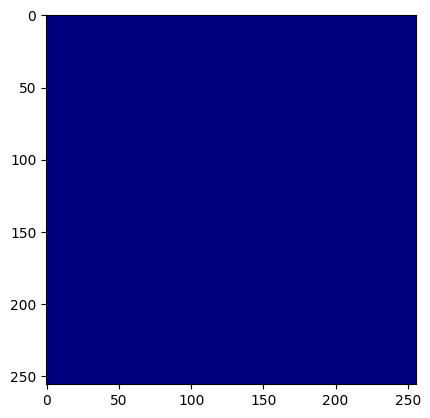

In [322]:
plt.imshow(pred[0,:,:]>0.5, cmap='jet')

In [314]:
plt.show(pred[])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

#### show the worst images

In [248]:
img_path = df.iloc[0]['img_path']

In [249]:
img_path

WindowsPath('C:/Users/Fabian/Documents/Github_Masterthesis/Solarpark-detection/data_local/data_splitted_undersampling/test/images/32UMD_105_2018-7-27.pt')

In [ ]:
def show_rgb_sample(sample):
    img, mask = sample
    plt.figure(figsize=(8, 8))
    plt.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)))
    plt.imshow(torch.Tensor.numpy(mask), cmap='jet', alpha=0.5*(torch.Tensor.numpy(mask)==True))

In [254]:
img = torch.load(img_path)

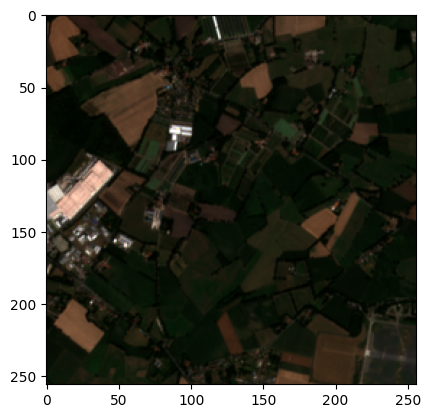

In [256]:
plt.imshow(torch.Tensor.numpy(img[1:4,:,:]).transpose((1,2,0)));